In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import functools
import io
import itertools
import shutil
import os
import json
import subprocess
from pathlib import Path

import dotenv
from box import Box

# visualization libraries
# %matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import seaborn as sns

# Computation & ML libraries.
import numpy as np
import pandas as pd
from IPython import display

mpl.rc_file_defaults()

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
FIGS_DIR = Path("figs")
FIGS_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
PAGE_WIDTH_INCHES = 7
COL_WIDTH_INCHES = 3.39
MIN_FONT_SIZE = 9

## HCP Results

In [5]:
print(
    plt.rcParams["font.size"],
    plt.rcParams["legend.fontsize"],
    plt.rcParams["legend.title_fontsize"],
)

9.0 medium None


In [ ]:
hcp_results_f = Path("hcp/voxelwise_metrics_results.csv")
hcp_results_table_dtypes = dict(
    subj_id="string",
    split="string",
    model_category="string",
    model_instance="string",
    tissue_mask="string",
    metric="string",
    mean_value="Float64",
    median_value="Float64",
    std_value="Float64",
)
_hcp_results_table = pd.read_csv(
    hcp_results_f,
    # dtype=hcp_results_table_dtypes,
    keep_default_na=False,
    na_values=(
        "#N/A",
        "-NaN",
        "-nan",
        "<NA>",
        "NA",
        "NULL",
        "NaN",
        "None",
        "nan",
        "null",
    ),
)

# Check for NaNs
print("NaN rows:")
print(_hcp_results_table[np.isnan(_hcp_results_table.mean_value)])

# Update some names/values
hcp_results_table = _hcp_results_table.copy(deep=True)
hcp_results_table.loc[
    hcp_results_table.model_category.map(lambda n: "fixed-net" in n.casefold()),
    "model_category",
] = "Fixed-Net"
hcp_results_table.loc[
    hcp_results_table.model_category.map(lambda n: "trilinear-dwi" in n.casefold()),
    "model_category",
] = "Trilin-DWI"
hcp_results_table.loc[
    hcp_results_table.model_category.map(lambda n: "trilinear-sh" in n.casefold()),
    "model_category",
] = "Trilin-SH"

# hcp_results_table.loc[
#     hcp_results_table.metric == "MSJSD", ("mean_value", "median_value", "std_value")
# ] = (
#     hcp_results_table.loc[
#         hcp_results_table.metric == "MSJSD", ("mean_value", "median_value", "std_value")
#     ]
#     * 1e4
# )
# hcp_results_table.loc[hcp_results_table.metric == "MSJSD", "metric"] = "MSJSD x 10^4"

hcp_results_table

### Raincloud Plot

In [ ]:
hcp_plot_f_basename = "hcp_vox_results_plot"
stat_of_interest = "mean_value"
tissue_mask_of_interest = "wm"

metrics_of_interest = ("WMSE", "MSJSD", "WAAE")
metric_arrow_map = {"WMSE": "↓", "MSJSD": "↓", "WAAE": "↓"}
models_of_interest = ("FENRI", "Fixed-Net", "Trilin-DWI")

model_colors = sns.color_palette("colorblind", n_colors=len(models_of_interest))
model_color_dict = {
    models_of_interest[i]: list(model_colors)[i] for i in range(len(models_of_interest))
}

In [ ]:
# Create a raincloud plot.
plot_table = hcp_results_table.copy(deep=True)

plot_table = plot_table.query(
    f"(model_category in {models_of_interest}) & "
    f"(metric in {metrics_of_interest}) & "
    f"(tissue_mask == '{tissue_mask_of_interest}')"
)

print(
    plt.rcParams["font.size"],
    plt.rcParams["legend.fontsize"],
    plt.rcParams["legend.title_fontsize"],
)

with mpl.rc_context(mpl.rc_params()):
    with sns.axes_style(
        "whitegrid",
        {"axes.xmargin": 0.0, "axes.ymargin": 0.0},
    ):
        print(
            plt.rcParams["font.size"],
            plt.rcParams["legend.fontsize"],
            plt.rcParams["legend.title_fontsize"],
        )
        figsize = (COL_WIDTH_INCHES, 2.35)
        fig = plt.figure(
            figsize=figsize,
            dpi=dict(mpl.rc_params())["figure.dpi"],
            layout="constrained",
        )
        # fig.set_tight_layout(False)

        g = sns.FacetGrid(
            plot_table,
            col="metric",
            row="model_category",
            row_order=models_of_interest,
            col_order=metrics_of_interest,
            # hue="model",
            # palette=color_dict,
            sharex="col",
            sharey="row",
            margin_titles=False,
            despine=False,
            gridspec_kws={
                "hspace": 0.0,
                "wspace": 0.000001,
                # "left": 0.03,
                # "right": 0.97,
                # "top": 0.97,
                # "bottom": 0.03,
            },
        )
        g.figure.set_tight_layout(False)
        g.figure.set_figheight(fig.get_figheight())
        g.figure.set_figwidth(fig.get_figwidth())

        g = g.map_dataframe(
            sns.stripplot,
            x=stat_of_interest,
            y="model_category",
            hue="model_category",
            palette=model_color_dict,
            jitter=0.08,
            size=1.45,
            edgecolor="white",
            linewidth=0.3,
            legend=False,
        )

        g = g.map_dataframe(
            sns.boxplot,
            x=stat_of_interest,
            y="model_category",
            orient="h",
            palette=model_color_dict,
            hue="model_category",
            showfliers=False,
            width=0.33,
            linewidth=1.0,
        )
        # sns.despine(g.figure, top=True, right=False, left=False, bottom=True)
        g.set_titles("")

        # Shift all current plots down by 1/4 of the axis size.
        for ax in g.axes.flatten():
            # Shift the scatter plots/points.
            points_artist = list(
                filter(
                    lambda a: isinstance(a, mpl.collections.PathCollection),
                    ax.get_children(),
                )
            )[0]
            curr_offsets = points_artist.get_offsets().data.copy()
            curr_offsets[:, 1] += 1 / 4
            points_artist.set_offsets(curr_offsets)

            # Shift the boxplot artists.
            # This is very hardcoded right now, assumes that these artists correspond
            # to the boxplot only.
            boxplot_artists = list(ax.get_children())[1:8]
            for a in boxplot_artists:
                # The whiskers & median line.
                if isinstance(a, mpl.lines.Line2D):
                    curr_offset = a.get_ydata()
                    curr_offset = curr_offset + 1 / 4
                    a.set_ydata(curr_offset)
                # The "box" body of the plot.
                elif isinstance(a, mpl.patches.Patch):
                    curr_tf = a.get_transform()
                    aff_translate = mpl.transforms.Affine2D().translate(tx=0, ty=1 / 4)
                    new_tf = mpl.transforms.composite_transform_factory(
                        aff_translate, curr_tf
                    )
                    a.set(transform=new_tf)
                else:
                    raise RuntimeError()

        g.figure.canvas.draw()

        for (model, metric), ax in g.axes_dict.items():
            ax.set_ylabel("")
            ax.set_xmargin(0.03)

            data = plot_table[
                (plot_table.model_category == model) & (plot_table.metric == metric)
            ].copy()

            xlim = ax.get_xlim()
            bbox_to_anchor = (xlim[0], -0.5, (xlim[1] - xlim[0]), 1 / 2)

            ax_inset = inset_axes(
                ax,
                width="100%",
                height="100%",
                loc="upper left",
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=ax.transData,
                borderpad=0,
                axes_kwargs=dict(
                    xticklabels=[],
                    yticklabels=[],
                    frame_on=False,
                    # xmargin=0.05,
                    ymargin=0.05,
                    # xmargin=0,
                    # ymargin=0,
                ),
            )
            ax_inset.set_xlim(*xlim)

            sns.kdeplot(
                data,
                x=stat_of_interest,
                hue="model_category",
                palette=model_color_dict,
                common_norm=False,
                fill=True,
                cut=0.5,
                legend=False,
                bw_adjust=0.75,
                ax=ax_inset,
            )
            ax_inset.set_xlabel("")
            ax_inset.set_ylabel("")
            ax_inset.grid(False)

            if model == models_of_interest[-1]:
                metric_label = metric
                if metric == "MSJSD":

                    ticker = mpl.ticker.FuncFormatter(
                        lambda x, pos: "{:.1f}".format(x * 1e4)
                    )
                    ax.xaxis.set_major_formatter(ticker)
                    metric_label = "MSJSD" + r"$\times 10^4$"
                ax.set_xlabel(f"{metric_label} {metric_arrow_map[metric]}")

            if metric == metrics_of_interest[0]:
                ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va="center")

            # tmp viz of bounding box
            # ax.add_patch(
            #     plt.Rectangle(
            #         (bbox_to_anchor[0], bbox_to_anchor[1]),
            #         bbox_to_anchor[2],
            #         bbox_to_anchor[3],
            #         lw=1,
            #         ls="--",
            #         ec="c",
            #         fc="none",
            #         transform=ax.transData,
            #         zorder=100000,
            #     )
            # )
        g.savefig(
            FIGS_DIR / f"{hcp_plot_f_basename}.pdf", bbox_inches="tight", pad_inches=0.0
        )
        g.savefig(
            FIGS_DIR / f"{hcp_plot_f_basename}.svg", bbox_inches="tight", pad_inches=0.0
        )
        g
print()
print(
    plt.rcParams["font.size"],
    plt.rcParams["legend.fontsize"],
    plt.rcParams["legend.title_fontsize"],
)

In [ ]:
# Display table of aggregate HCP scores

plot_table = hcp_results_table.copy(deep=True)

plot_table = plot_table.query(
    f"(model_category in {models_of_interest}) & "
    f"(metric in {metrics_of_interest}) & "
    f"(tissue_mask == '{tissue_mask_of_interest}')"
)

plot_table = plot_table.loc[:, ("model_category", "metric", stat_of_interest)]
print("MEAN")
print(plot_table.groupby(["model_category", "metric"]).mean())
print("STD")
print(plot_table.groupby(["model_category", "metric"]).std())

## ISMRM-Sim Results

In [6]:
models_of_interest = ("FENRI", "Fixed-Net", "Trilin-DWI")

model_colors = sns.color_palette("colorblind", n_colors=len(models_of_interest))
model_color_dict = {
    models_of_interest[i]: list(model_colors)[i] for i in range(len(models_of_interest))
}

In [7]:
bundles_of_interest = (
    "CC_temporal",
    "CC_u_shaped",
    # "CC_ventro_striatal1",
    # "CC_ventro_striatal2",
    "UF_left",
    "UF_right",
    "OR_left",
    "OR_right",
    "SLF_left",
    "SLF_right",
    "ILF_left",
    "ILF_right",
    "Cingulum_left",
    "Cingulum_right",
    "BPS_left",
    "BPS_right",
)


metrics_of_interest = (
    # "total_streamlines",
    # "total_streamlines_over_full_res_score",
    # "VS_ratio",
    # "VS_ratio_over_full_res_score",
    # "IS",
    # "IS_over_full_res_score",
    # "IS_ratio",
    # "IS_ratio_over_full_res_score",
    # "VS",
    # "VS_over_full_res_score",
    # "TP",
    # "TP_over_full_res_score",
    # "FP",
    # "FP_over_full_res_score",
    # "FN",
    # "FN_over_full_res_score",
    "OL",
    # "OL_over_full_res_score",
    # "OR_pct_vs",
    # "OR_pct_vs_over_full_res_score",
    "OR_pct_gt",
    # "OR_pct_gt_over_full_res_score",
    "f1",
    # "f1_over_full_res_score",
    # "endpoints_OL",
    # "endpoints_OL_over_full_res_score",
    # "endpoints_OR",
    # "endpoints_OR_over_full_res_score",
)

# metrics_of_interest = (
#     "total_streamlines",
#     "total_streamlines_over_full_res_score",
#     "VS_ratio",
#     "VS_ratio_over_full_res_score",
#     "IS",
#     "IS_over_full_res_score",
#     "IS_ratio",
#     "IS_ratio_over_full_res_score",
#     "VS",
#     "VS_over_full_res_score",
#     "TP",
#     "TP_over_full_res_score",
#     "FP",
#     "FP_over_full_res_score",
#     "FN",
#     "FN_over_full_res_score",
#     "OL",
#     "OL_over_full_res_score",
#     "OR_pct_vs",
#     "OR_pct_vs_over_full_res_score",
#     "OR_pct_gt",
#     "OR_pct_gt_over_full_res_score",
#     "f1",
#     "f1_over_full_res_score",
#     "endpoints_OL",
#     "endpoints_OL_over_full_res_score",
#     "endpoints_OR",
#     "endpoints_OR_over_full_res_score",
# )


tract_metrics_arrow_map = {
    "total_streamlines": "",
    "total_streamlines_over_full_res_score": "",
    "VS_ratio": "↑",
    "VS_ratio_over_full_res_score": "↑",
    "IS": "↓",
    "IS_over_full_res_score": "↓",
    "IS_ratio": "↓",
    "IS_ratio_over_full_res_score": "↓",
    "VS": "↑",
    "VS_over_full_res_score": "↑",
    "TP": "↑",
    "TP_over_full_res_score": "↑",
    "FP": "↓",
    "FP_over_full_res_score": "↓",
    "FN": "↓",
    "FN_over_full_res_score": "↓",
    "OL": "↑",
    "OL_over_full_res_score": "↑",
    "OR_pct_vs": "↓",
    "OR_pct_vs_over_full_res_score": "↓",
    "OR_pct_gt": "↓",
    "OR_pct_gt_over_full_res_score": "↓",
    "f1": "↑",
    "f1_over_full_res_score": "↑",
    "endpoints_OL": "↑",
    "endpoints_OL_over_full_res_score": "↑",
    "endpoints_OR": "↓",
    "endpoints_OR_over_full_res_score": "↓",
}

tract_metrics_units_map = {
    "total_streamlines": "(streams)",
    "total_streamlines_over_full_res_score": "",
    "VS_ratio": "(streams)",
    "VS_ratio_over_full_res_score": "",
    "IS": "(streams)",
    "IS_over_full_res_score": "",
    "IS_ratio": "",
    "IS_ratio_over_full_res_score": "",
    "VS": "(streams)",
    "VS_over_full_res_score": "",
    "TP": "(vox)",
    "TP_over_full_res_score": "",
    "FP": "(vox)",
    "FP_over_full_res_score": "",
    "FN": "(vox)",
    "FN_over_full_res_score": "",
    "OL": "(vox)",
    "OL_over_full_res_score": "",
    "OR_pct_vs": "",
    "OR_pct_vs_over_full_res_score": "",
    "OR_pct_gt": "",
    "OR_pct_gt_over_full_res_score": "",
    "f1": "",
    "f1_over_full_res_score": "",
    "endpoints_OL": "(vox)",
    "endpoints_OL_over_full_res_score": "",
    "endpoints_OR": "(vox)",
    "endpoints_OR_over_full_res_score": "",
}

tract_model_rename_map = {
    "fixed-net": "Fixed-Net",
    "fenri": "FENRI",
    "trilin-dwi": "Trilin-DWI",
    "trilin-sh": "Trilin-SH",
    "fenri-pred_trilin-tract": "FENRI-Trilin",
    "full_res": "Ceiling",
}

In [8]:
sim_results_f = Path("ismrm_sim/model_tractography_scores.csv")
fr_ceiling_results_f = Path("ismrm_sim/full_res_comparison_scores.csv")

_sim_results_table = pd.read_csv(sim_results_f, comment="#", skip_blank_lines=True)
_sim_results_table.loc[:, "orig_metric_name"] = _sim_results_table.metric_name
_ceil_results_table = pd.read_csv(
    fr_ceiling_results_f, comment="#", skip_blank_lines=True
)
_ceil_results_table.loc[:, "orig_metric_name"] = _ceil_results_table.metric_name


# Check for NaNs
print("NaN rows:")
print(_sim_results_table[np.isnan(_sim_results_table.value)])

# Update some names/values
sim_results_table = _sim_results_table.copy(deep=True)
reduced_sim_results_table = sim_results_table.query(
    f"(metric_name in {metrics_of_interest}) & " f"(bundle in {bundles_of_interest})"
).copy(deep=True)
ceil_results_table = _ceil_results_table.copy(deep=True)
reduced_ceil_results_table = ceil_results_table.query(
    f"(metric_name in {metrics_of_interest}) & " f"(bundle in {bundles_of_interest})"
).copy(deep=True)


def clean_bundle_names(s):
    s = s.replace("_left", "-L")
    s = s.replace("_right", "-R")
    s = s.replace("_", " ")
    return s


def clean_metric_names(s):
    if "total_streamlines" in s.casefold():
        s = s.replace("total", "num")
    s = s.replace("_over_full_res_score", " / FR")
    s = s.replace("pct", "%")
    s = s.replace("_", " ")
    # s = s.capitalize()
    return s.strip()


# Add metric direction arrows.
sim_results_table.loc[:, "metric_name"] = sim_results_table.metric_name.map(
    lambda m: f"{m} {tract_metrics_arrow_map[m]}".strip()
)
reduced_sim_results_table.loc[
    :, "metric_name"
] = reduced_sim_results_table.metric_name.map(
    lambda m: f"{m} {tract_metrics_arrow_map[m]}".strip()
)
ceil_results_table.loc[:, "metric_name"] = ceil_results_table.metric_name.map(
    lambda m: f"{m} {tract_metrics_arrow_map[m]}".strip()
)
reduced_ceil_results_table.loc[
    :, "metric_name"
] = reduced_ceil_results_table.metric_name.map(
    lambda m: f"{m} {tract_metrics_arrow_map[m]}".strip()
)
# Clean bundle names.
sim_results_table.loc[:, "bundle"] = sim_results_table.bundle.map(clean_bundle_names)
reduced_sim_results_table.loc[:, "bundle"] = reduced_sim_results_table.bundle.map(
    clean_bundle_names
)
ceil_results_table.loc[:, "bundle"] = ceil_results_table.bundle.map(clean_bundle_names)
reduced_ceil_results_table.loc[:, "bundle"] = reduced_ceil_results_table.bundle.map(
    clean_bundle_names
)
# Clean metric names.
sim_results_table.loc[:, "metric_name"] = sim_results_table.metric_name.map(
    clean_metric_names
)
reduced_sim_results_table.loc[
    :, "metric_name"
] = reduced_sim_results_table.metric_name.map(clean_metric_names)
ceil_results_table.loc[:, "metric_name"] = ceil_results_table.metric_name.map(
    clean_metric_names
)
reduced_ceil_results_table.loc[
    :, "metric_name"
] = reduced_ceil_results_table.metric_name.map(clean_metric_names)
# Rename models.
sim_results_table.loc[:, "model_name"] = sim_results_table.model_name.map(
    tract_model_rename_map
)
reduced_sim_results_table.loc[
    :, "model_name"
] = reduced_sim_results_table.model_name.map(tract_model_rename_map)
ceil_results_table.loc[:, "model_name"] = ceil_results_table.model_name.map(
    tract_model_rename_map
)
reduced_ceil_results_table.loc[
    :, "model_name"
] = reduced_ceil_results_table.model_name.map(tract_model_rename_map)


sim_results_table

NaN rows:
                   model_name     subj_id               bundle  \
5463                    fenri  sim-126426  CC_ventro_striatal2   
5469                    fenri  sim-126426  CC_ventro_striatal2   
5471                    fenri  sim-126426  CC_ventro_striatal2   
5473                    fenri  sim-126426  CC_ventro_striatal2   
5475                    fenri  sim-126426  CC_ventro_striatal2   
5477                    fenri  sim-126426  CC_ventro_striatal2   
5479                    fenri  sim-126426  CC_ventro_striatal2   
5481                    fenri  sim-126426  CC_ventro_striatal2   
5483                    fenri  sim-126426  CC_ventro_striatal2   
5485                    fenri  sim-126426  CC_ventro_striatal2   
5487                    fenri  sim-126426  CC_ventro_striatal2   
5911                fixed-net  sim-126426  CC_ventro_striatal2   
5917                fixed-net  sim-126426  CC_ventro_striatal2   
5919                fixed-net  sim-126426  CC_ventro_striatal2   


,model_name,subj_id,bundle,metric_name,value,orig_metric_name
0,FENRI,sim-965367,CC temporal,num streamlines,1895.000000,total_streamlines
1,FENRI,sim-965367,CC temporal,num streamlines / FR,0.942317,total_streamlines_over_full_res_score
2,FENRI,sim-965367,CC temporal,VS ratio ↑,0.055937,VS_ratio
3,FENRI,sim-965367,CC temporal,VS ratio / FR ↑,1.249870,VS_ratio_over_full_res_score
4,FENRI,sim-965367,CC temporal,IS ↓,1789.000000,IS
...,...,...,...,...,...,...
8955,FENRI-Trilin,sim-859671,BPS-R,f1 / FR ↑,0.824859,f1_over_full_res_score
8956,FENRI-Trilin,sim-859671,BPS-R,endpoints OL ↑,1301.000000,endpoints_OL
8957,FENRI-Trilin,sim-859671,BPS-R,endpoints OL / FR ↑,0.725195,endpoints_OL_over_full_res_score
8958,FENRI-Trilin,sim-859671,BPS-R,endpoints OR ↓,276.000000,endpoints_OR


In [9]:
# Try and keep the bundles somewhat intact?
# plot_table = sim_results_table.copy(deep=True)
# Combine left and right
# plot_table.loc[:, "bundle"] = plot_table.bundle.map(lambda b: b.replace('-L', '').replace('-R', ''))

# plot_table = plot_table.loc[:, ("model_name", "bundle", "metric_name", "value")]
# mean_results = plot_table.groupby(["metric_name", "model_name", "bundle"]).mean()
# # mean_results.pivot_table(values='value', index=[""])

9.0


9.0
9.0



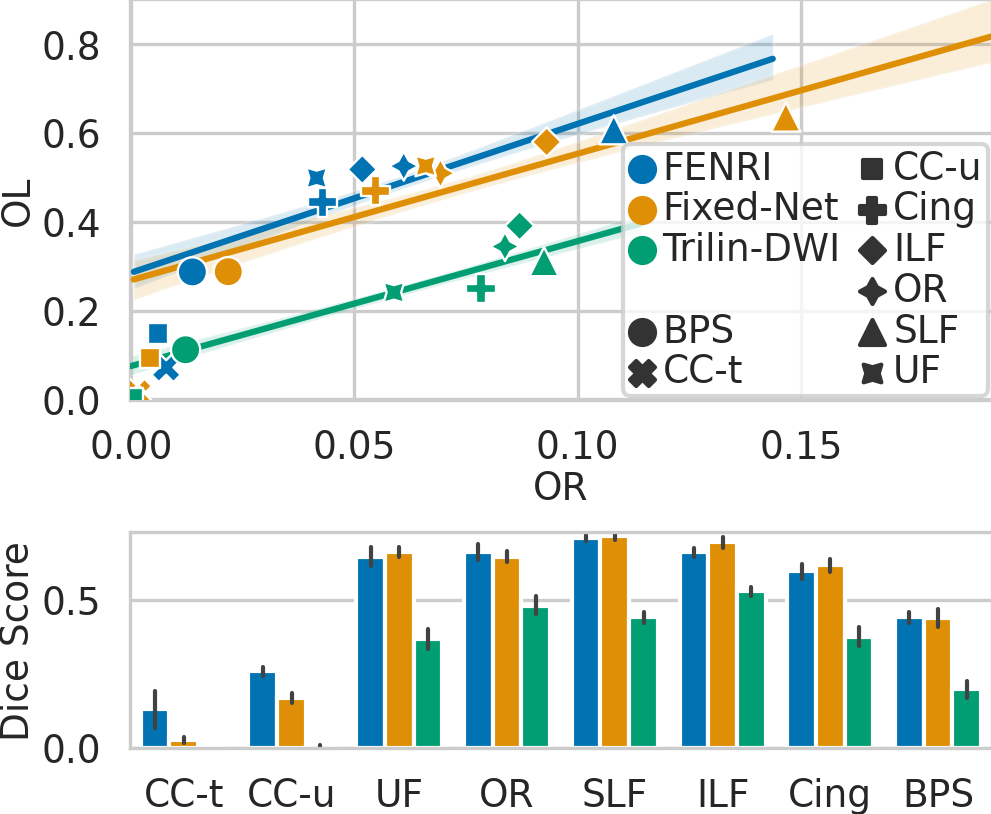

In [38]:
# Display dual-plot of results.
plot_table = reduced_sim_results_table.copy(deep=True)
# Only keep some model results before adding a ceiling.
plot_table = plot_table.query(f"model_name in {models_of_interest}")
# Add the ceiling FR result as its own model.
plot_table = pd.concat(
    [plot_table, reduced_ceil_results_table], axis=0, ignore_index=True
)
# Merge left and right bundles by renaming to a common name.
all_bundles = plot_table.bundle.unique().tolist()
bundle_merger = dict()
for b in all_bundles:
    s = b.strip()
    if s.endswith("-L"):
        bundle_merger[b] = b.replace("-L", "")
    elif s.endswith("-R"):
        bundle_merger[b] = b.replace("-R", "")
    else:
        bundle_merger[b] = b
plot_table.bundle = plot_table.bundle.map(bundle_merger)

# Shorten bundle names.
bundle_shortener = {
    "UF": "UF",
    "SLF": "SLF",
    "ILF": "ILF",
    "OR": "OR",
    "BPS": "BPS",
    "CC temporal": "CC-t",
    "CC u shaped": "CC-u",
    "Cingulum": "Cing",
}
plot_table.bundle = plot_table.bundle.map(bundle_shortener)
# plot_table.loc[:, "unique_idx"] = np.arange(plot_table.shape[0])

print(plt.rcParams["font.size"], flush=True)

with mpl.rc_context(
    mpl.rc_params()
    | {
        "font.size": 9.0,
        "legend.markerscale": 1.0,
        "legend.borderpad": 0.15,
        "legend.labelspacing": 0.1,
        "legend.handlelength": 0.7,
        "legend.columnspacing": 0.5,
        "legend.handletextpad": 0.2,
        "legend.borderaxespad": 0.1,
    }
):
    with sns.axes_style(
        "whitegrid",
        {"axes.xmargin": 0.0, "axes.ymargin": 0.0},
    ):
        fig, axs = plt.subplots(
            nrows=2,
            sharex=False,
            sharey=False,
            figsize=(COL_WIDTH_INCHES, 2.8),
            gridspec_kw={"height_ratios": [0.65, 0.35], "hspace": 0.0001},
        )
        print(plt.rcParams["font.size"], flush=True)

        # Top plot: scatter plot of OL vs OR %
        ax = axs[0]

        ol_data = plot_table[
            plot_table.orig_metric_name.map(lambda m: "ol" in m.lower().strip())
        ].copy(deep=True)
        ol_data = ol_data.loc[
            :, ("model_name", "subj_id", "bundle", "orig_metric_name", "value")
        ]
        or_data = plot_table[
            plot_table.orig_metric_name.map(lambda m: "or" in m.lower().strip())
        ].copy(deep=True)
        or_data = or_data.loc[
            :, ("model_name", "subj_id", "bundle", "orig_metric_name", "value")
        ]
        ol_or_data = ol_data.merge(
            or_data,
            how="inner",
            on=["model_name", "subj_id", "bundle"],
            suffixes=["_ol", "_or"],
        )
        ol_or_data = pd.DataFrame.from_dict(
            {
                "model_name": ol_or_data.model_name,
                "bundle": ol_or_data.bundle,
                "subj_id": ol_or_data.subj_id,
                "OL": ol_or_data.value_ol,
                "OR_pct_gt": ol_or_data.value_or,
            }
        )

        # Only plot model results, not the ceiling.
        model_ol_or_data = ol_or_data.query(f"model_name in {models_of_interest}").copy(
            deep=True
        )
        # Plot regression lines of the OL-OR curve.
        for model in models_of_interest:
            d = model_ol_or_data[model_ol_or_data.model_name == model]
            c = model_color_dict[model]
            sns.regplot(
                d,
                x="OR_pct_gt",
                y="OL",
                x_ci="ci",
                ci=95,
                order=1,
                n_boot=10000,
                scatter=False,
                color=c,
                line_kws={"lw": 1.5, "zorder": 3},
                ax=ax,
            )

        # Plot points as averages.
        mean_model_ol_or_data = model_ol_or_data.groupby(["model_name", "bundle"]).mean(
            numeric_only=True
        )

        scatter = sns.scatterplot(
            mean_model_ol_or_data,
            # model_ol_or_data, # Uncomment to get all results plotted
            x="OR_pct_gt",
            y="OL",
            style="bundle",
            hue="model_name",
            s=7**2,
            # s=3**2,
            # alpha=0.7,
            palette=model_color_dict,
            zorder=5,
            ax=ax,
        )
        # Fix the legend text.
        new_legend_handles = list()
        new_legend_labels = list()
        empty_handle = None
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label == "model_name" or label == "bundle":
                empty_handle = handle
                continue
            new_legend_handles.append(handle)
            new_legend_labels.append(label)
        # Fill the first column with blank handlers to push the model colors to the left
        # col, and the bundle shapes to the right.
        new_legend_handles.insert(3, empty_handle)
        new_legend_labels.insert(3, "")
        # new_legend_handles.insert(4, empty_handle)
        # new_legend_labels.insert(4, "")
        # new_legend_handles.insert(4, empty_handle)
        # new_legend_labels.insert(4, "")
        ax.legend(handles=new_legend_handles, labels=new_legend_labels, ncol=2)

        ax.set_xlabel("OR")

        # Bottom plot: f1 of each model x bundle
        ax = axs[1]

        f1_data = plot_table[
            plot_table.orig_metric_name.map(lambda m: "f1" in m.lower().strip())
        ].copy(deep=True)
        f1_data = f1_data.loc[:, ("model_name", "subj_id", "bundle", "value")]

        sns.barplot(
            f1_data,
            x="bundle",
            y="value",
            hue="model_name",
            errorbar=("ci", 95),
            n_boot=10000,
            saturation=1,
            errwidth=1.0,
            hue_order=models_of_interest,
            palette=model_color_dict,
            ax=ax,
        )
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("Dice Score")

        print(plt.rcParams["font.size"], flush=True)
        plt.savefig(
            FIGS_DIR / "ismrm_sim_results.pdf", bbox_inches="tight", pad_inches=0.0
        )
        plt.savefig(
            FIGS_DIR / "ismrm_sim_results.svg", bbox_inches="tight", pad_inches=0.0
        )

print()

In [ ]:
# Display all metrics, aggregated over all bundles.

plot_table = sim_results_table.copy(deep=True)
# Add the ceiling FR result as its own model.
plot_table = pd.concat([plot_table, ceil_results_table], axis=0, ignore_index=True)

# Append units to the full results table.
plot_table.loc[:, "metric_name"] = plot_table.index.map(
    lambda i: f"{plot_table.metric_name[i]} {tract_metrics_units_map[plot_table.orig_metric_name[i]]}".strip()
)

plot_table = plot_table.loc[:, ("model_name", "metric_name", "value")]
mean_results = plot_table.groupby(["model_name", "metric_name"]).mean()
std_results = plot_table.groupby(["model_name", "metric_name"]).std()

# mean_results.style.to_latex()
mean_results = mean_results.pivot_table(
    values="value", index="model_name", columns="metric_name"
)
std_results = std_results.pivot_table(
    values="value", index="model_name", columns="metric_name"
)
mean_results_dict = mean_results.to_dict()
std_results_dict = std_results.to_dict()

stat_results = mean_results.copy(deep=True)
stat_results_dict = stat_results.to_dict()

for metric_i in mean_results_dict.keys():
    for model_j in mean_results_dict[metric_i].keys():
        mean_val = mean_results_dict[metric_i][model_j]
        std_val = std_results_dict[metric_i][model_j]
        stat = rf"{mean_val:.3g} ± {std_val:.3g}"
        stat_results_dict[metric_i][model_j] = stat

stat_results = pd.DataFrame.from_dict(stat_results_dict)
# display.HTML(stat_results.to_html())
for idx_start, idx_stop in zip((0, 10, 20), (10, 20, 28)):
    print(stat_results.iloc[:, idx_start:idx_stop].style.to_latex())
# print(stat_results.style.to_latex())

In [ ]:
# Plot only metrics of interest.
# Aggregate over all bundles
plot_table = reduced_sim_results_table.copy(deep=True)

plot_table = plot_table.loc[:, ("model_name", "metric_name", "value")]
mean_results = plot_table.groupby(["model_name", "metric_name"]).mean()
std_results = plot_table.groupby(["model_name", "metric_name"]).std()

# mean_results.style.to_latex()
mean_results = mean_results.pivot_table(
    values="value", index="model_name", columns="metric_name"
)
std_results = std_results.pivot_table(
    values="value", index="model_name", columns="metric_name"
)
mean_results_dict = mean_results.to_dict()
std_results_dict = std_results.to_dict()

stat_results = mean_results.copy(deep=True)
stat_results_dict = stat_results.to_dict()

for metric_i in mean_results_dict.keys():
    for model_j in mean_results_dict[metric_i].keys():
        mean_val = mean_results_dict[metric_i][model_j]
        std_val = std_results_dict[metric_i][model_j]
        stat = rf"${mean_val:.3g} \pm {std_val:.3g}$"
        stat_results_dict[metric_i][model_j] = stat

stat_results = pd.DataFrame.from_dict(stat_results_dict)
print(stat_results.to_markdown())

In [ ]:
stat_results

In [ ]:
print(mean_results.to_markdown())